In [1]:
import os
import pandas as pd
from google.cloud import bigquery
from pymongo import MongoClient

# ------------------------------------------------------------------------------
# 🔐 STEP 1: Authenticate with Google Cloud using service account credentials
# ------------------------------------------------------------------------------
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"D:\Keys\python-access-key.json"

# ------------------------------------------------------------------------------
# 🧠 STEP 2: Initialize BigQuery client for querying GDELT data
# ------------------------------------------------------------------------------
client = bigquery.Client()

# ------------------------------------------------------------------------------
# 📡 STEP 3: Define SQL query to fetch mental health-related events from GDELT
# ------------------------------------------------------------------------------
query = """
SELECT
  PARSE_DATE('%Y%m%d', CAST(SQLDATE AS STRING)) AS date,
  Actor1Name,
  Actor2Name,
  Actor1CountryCode,
  EventCode,
  AvgTone
FROM
  `gdelt-bq.gdeltv2.events`
WHERE
  EventCode IN ('1122', '1123', '122', '125')  -- Suicide Threat, Attempt, Help Request
  AND SQLDATE BETWEEN 20150218 AND 20250331     -- From Feb 18, 2015 to March 31, 2025
"""

# ------------------------------------------------------------------------------
# ⏳ STEP 4: Execute query and convert results into a DataFrame
# ------------------------------------------------------------------------------
print("🔄 Fetching GDELT data from BigQuery...")
query_job = client.query(query)
gdelt_df = query_job.result().to_dataframe()
print(f"✅ Retrieved {len(gdelt_df)} records from GDELT.")

# ------------------------------------------------------------------------------
# 🗃️ STEP 5: Enrich data with time features (year, month)
# ------------------------------------------------------------------------------
gdelt_df["date"] = pd.to_datetime(gdelt_df["date"])
gdelt_df["year"] = gdelt_df["date"].dt.year
gdelt_df["month"] = gdelt_df["date"].dt.month

# ------------------------------------------------------------------------------
# 🌍 STEP 6: Connect to MongoDB and insert cleaned data
# ------------------------------------------------------------------------------
mongo_client = MongoClient("mongodb://localhost:27017/")
db = mongo_client["mental_health_db"]
collection = db["GDELT_raw_data"]

# ⚠️ Clear previous data (optional)
collection.delete_many({})
collection.insert_many(gdelt_df.to_dict(orient="records"))

# ------------------------------------------------------------------------------
# ✅ STEP 7: Confirmation message
# ------------------------------------------------------------------------------
print(f"✅ Successfully inserted {len(gdelt_df)} GDELT event records into MongoDB (mental_health_project.gdelt_events)")


🔄 Fetching GDELT data from BigQuery...


c:\Users\ADMIN\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1933: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


✅ Retrieved 2751835 records from GDELT.
✅ Successfully inserted 2751835 GDELT event records into MongoDB (mental_health_project.gdelt_events)


In [5]:
import pandas as pd
from pymongo import MongoClient
from sqlalchemy import create_engine

# ------------------------------------------------------------------------
# 🌐 Step 1: Connect to MongoDB and Fetch Raw Data
# ------------------------------------------------------------------------
print("🔄 Connecting to MongoDB and fetching data...")
client = MongoClient("mongodb://localhost:27017/")
db = client["mental_health_db"]
collection = db["GDELT_raw_data"]

raw_df = pd.DataFrame(list(collection.find()))
raw_count = len(raw_df)
print(f"📊 Raw records loaded: {raw_count:,} rows")

# ------------------------------------------------------------------------
# 🧼 Step 2: Data Cleaning
# ------------------------------------------------------------------------

# Drop Mongo's default _id column
if "_id" in raw_df.columns:
    raw_df.drop(columns=["_id"], inplace=True)

# Remove null country codes
raw_df = raw_df[raw_df["Actor1CountryCode"].notna()]

# Remove null/invalid dates
raw_df = raw_df[raw_df["date"].notna()]
raw_df["date"] = pd.to_datetime(raw_df["date"], errors="coerce")
raw_df = raw_df[raw_df["date"].notna()]

# Filter relevant EventCodes
event_map = {
    "1122": "suicide_threat",
    "1123": "suicide_attempt",
    "125": "help_request",
    "122": "mental_expression"
}
raw_df = raw_df[raw_df["EventCode"].isin(event_map.keys())]

# Add event_type
raw_df["event_type"] = raw_df["EventCode"].map(event_map)

# Extract year and month
raw_df["year"] = raw_df["date"].dt.year
raw_df["month"] = raw_df["date"].dt.month
raw_df.rename(columns={"Actor1CountryCode": "country"}, inplace=True)

cleaned_count = len(raw_df)

# ------------------------------------------------------------------------
# 📊 Step 3: Summarize the Data
# ------------------------------------------------------------------------
summary_df = raw_df.groupby(["year", "month", "country", "event_type"]).agg(
    event_count=("EventCode", "count"),
    avg_tone=("AvgTone", "mean")
).reset_index()

summary_count = len(summary_df)

# ------------------------------------------------------------------------
# 🛢️ Step 4: Store in PostgreSQL
# ------------------------------------------------------------------------
pg_user = "postgres"
pg_password = "hari"
pg_host = "localhost"
pg_port = "5432"
pg_db = "mental_health_project"

engine = create_engine(f"postgresql://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_db}")

summary_df.to_sql("GDELT_cleaned_data", con=engine, if_exists="replace", index=False)

# ------------------------------------------------------------------------
# 🧾 Final Output Log
# ------------------------------------------------------------------------
print(f"🧼 After cleaning: {summary_count:,} summarized rows")
print("📤 Cleaned data successfully stored in PostgreSQL table: GDELT_cleaned_data")


🔄 Connecting to MongoDB and fetching data...
📊 Raw records loaded: 2,751,835 rows
🧼 After cleaning: 47,954 summarized rows
📤 Cleaned data successfully stored in PostgreSQL table: GDELT_cleaned_data


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21864\2422607680.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


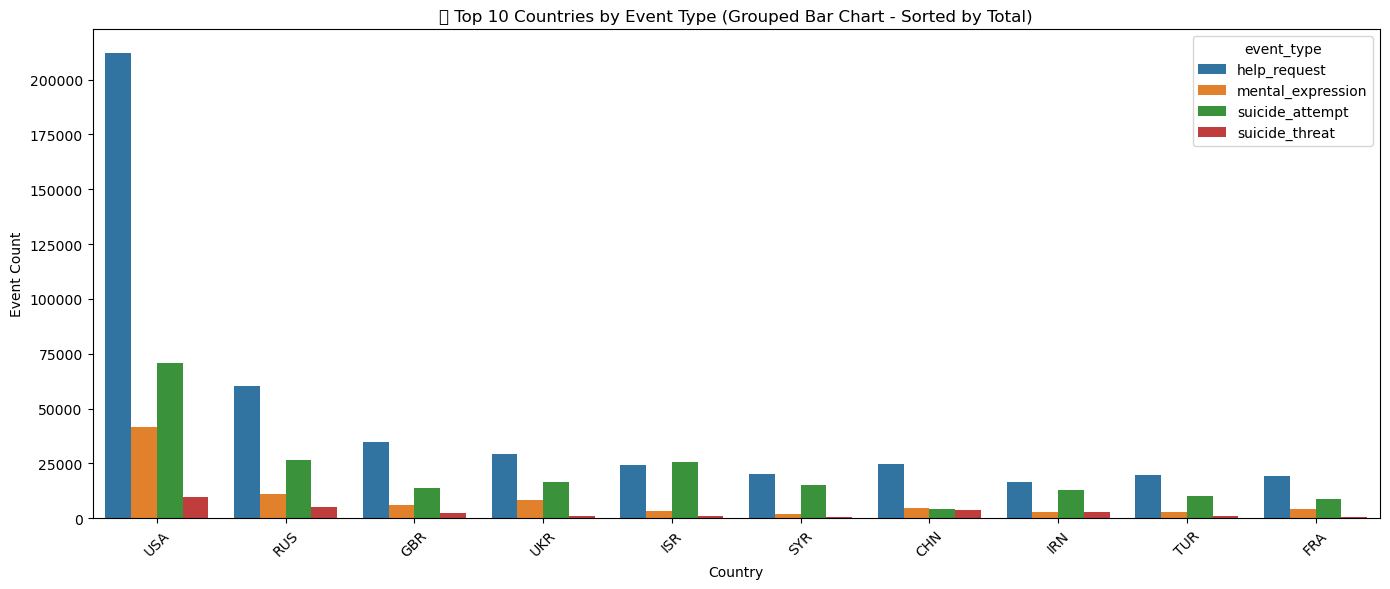

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21864\2422607680.py:53: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128309 (\N{LARGE BLUE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


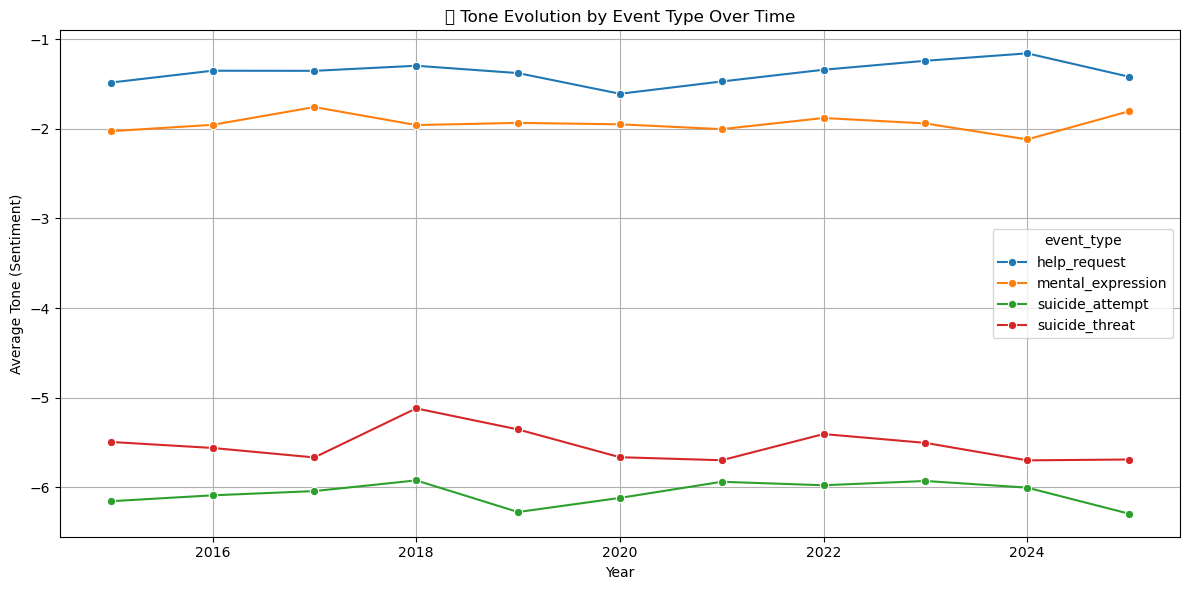

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_21864\2422607680.py:67: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1200x600 with 0 Axes>

C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129521 (\N{BRICK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


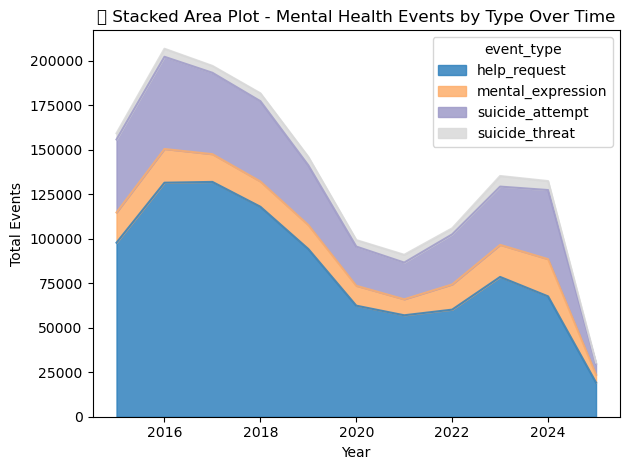

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# ---------------------------------------------------------------------
# 🔌 Database Connection
# ---------------------------------------------------------------------
pg_user = "postgres"
pg_password = "hari"
pg_host = "localhost"
pg_port = "5432"
pg_db = "mental_health_project"

engine = create_engine(f"postgresql://{pg_user}:{pg_password}@{pg_host}:{pg_port}/{pg_db}")
df = pd.read_sql("SELECT * FROM gdelt_cleaned_summary", con=engine)

# ---------------------------------------------------------------------
# 📊 1. Grouped Bar Chart: Top Countries by Event Type (Sorted by Total)
# ---------------------------------------------------------------------
top_countries = df.groupby("country")["event_count"].sum().nlargest(10).index
grouped_data = df[df["country"].isin(top_countries)]
grouped_summary = grouped_data.groupby(["country", "event_type"])["event_count"].sum().reset_index()

# Sort countries by total event count
country_order = (
    grouped_summary.groupby("country")["event_count"]
    .sum()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(14, 6))
sns.barplot(data=grouped_summary, x="country", y="event_count", hue="event_type", order=country_order)
plt.title("📊 Top 10 Countries by Event Type (Grouped Bar Chart - Sorted by Total)")
plt.xlabel("Country")
plt.ylabel("Event Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 🔵 2. Line Plot: Tone Evolution Over Time by Event Type
# ---------------------------------------------------------------------
tone_over_time = df.groupby(["year", "event_type"])["avg_tone"].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=tone_over_time, x="year", y="avg_tone", hue="event_type", marker="o")
plt.title("🔵 Tone Evolution by Event Type Over Time")
plt.ylabel("Average Tone (Sentiment)")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------
# 🧱 3. Stacked Area Chart: Mental Health Events by Type Over Time
# ---------------------------------------------------------------------
area_data = df.groupby(["year", "event_type"])["event_count"].sum().unstack().fillna(0)
area_data.index = area_data.index.astype(int)

plt.figure(figsize=(12, 6))
area_data.plot.area(stacked=True, colormap="tab20c", alpha=0.85)
plt.title("🧱 Stacked Area Plot - Mental Health Events by Type Over Time")
plt.xlabel("Year")
plt.ylabel("Total Events")
plt.tight_layout()
plt.show()
